In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.spatial.distance import cosine, jensenshannon, euclidean

import torch
import timm


from sklearn.linear_model import RidgeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, f1_score

np.random.seed(1234)

num_figures = 10000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


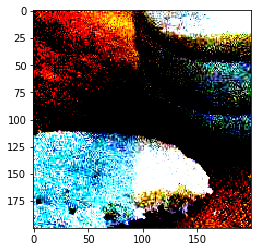

CPU times: user 51.4 s, sys: 830 ms, total: 52.2 s
Wall time: 55.9 s


In [2]:
%%time
features = []

target_nx = 200
target_ny = 200

extract_ratio = 2e-2

random_part = np.random.rand(target_nx*target_ny) < extract_ratio
random_part = np.array([random_part]*3).reshape(target_nx, target_ny, 3)
#random_part = random_part.reshape(target_nx, target_ny, 3)

#transformer = PowerTransformer('yeo-johnson', standardize=True)
#transformer = MinMaxScaler()
#transformer = QuantileTransformer(n_quantiles=100, output_distribution='uniform')
transformer = StandardScaler()

for i in range(num_figures):
    im = plt.imread('task4_be9ai3nsdj/food/' + f'{i:05d}' +'.jpg')
    
    nx, ny, nc = np.shape(im)
    
    start_idx = int((nx - target_nx)/2)
    end_idx = target_nx + start_idx
    
    start_idy = int((ny - target_ny)/2)
    end_idy = target_ny + start_idy
        
    im_cropped = im[start_idx:end_idx, start_idy:end_idy, :]
    
    
    im_normalized = im_cropped
    im_normalized = np.array([transformer.fit_transform(im_cropped[:,:,0]),
                    transformer.fit_transform(im_cropped[:,:,1]),
                    transformer.fit_transform(im_cropped[:,:,2])])
    
    im_normalized = im_normalized.transpose(1, 2, 0)
    
    features.append(im_normalized[random_part])
    
plt.figure()
plt.imshow(im_normalized)
plt.show()

In [2]:
#np.save('features', np.array(features))
features = np.load('features_inception_v4.npy')

In [3]:
triplets = pd.read_csv('task4_be9ai3nsdj/train_triplets.txt', header=None, delimiter=' ', dtype=str).to_numpy()
triplets_id = pd.read_csv('task4_be9ai3nsdj/train_triplets.txt', header=None, delimiter=' ', dtype=int).to_numpy()
test_triplets_id = pd.read_csv('task4_be9ai3nsdj/test_triplets.txt', header=None, delimiter=' ', dtype=int).to_numpy()

In [4]:
num_feature = len(features[0])
num_obsv = len(triplets_id)

triplets_id_appended = np.append(triplets_id, np.array([triplets_id[:,0], triplets_id[:,2], triplets_id[:,1]]).T, axis=0)

train_observation = np.zeros(len(triplets_id_appended))
train_observation[:num_obsv] = 1

In [5]:
print(num_feature)

1536


In [6]:
feature_transformed = []

for id_list in triplets_id_appended:
    feature_transformed.append([features[idx] for idx in id_list][0])
    
feature_transformed = np.array(feature_transformed)

In [7]:
test_feature_transformed = []

for id_list in test_triplets_id:
    test_feature_transformed.append([features[idx] for idx in id_list][0])
    
test_feature_transformed = np.array(test_feature_transformed)

In [8]:
score_func = make_scorer(f1_score)

In [19]:
%%time
kf = KFold(n_splits=3, shuffle=False, random_state=None)
model = MLPClassifier(hidden_layer_sizes=1, activation='identity',
                      solver='lbfgs', max_iter=3000, tol=1e-5, alpha=1e-3)
                      #warm_start=True)

for train_idx, test_idx in kf.split(triplets_id):
    
    train_idx = [*train_idx, *(train_idx + num_obsv)]
    test_idx = [*test_idx, *(test_idx + num_obsv)]
    
    model.fit(feature_transformed[train_idx], train_observation[train_idx])
    
    prediction = model.predict(feature_transformed[test_idx])
    
    print(f1_score(train_observation[test_idx], prediction))

0.5235476356300584
0.5647079475139334
0.6427773976302805
CPU times: user 2min 41s, sys: 9.39 s, total: 2min 50s
Wall time: 1min 23s


In [21]:
%%time
model.fit(feature_transformed, train_observation)

CPU times: user 55.2 s, sys: 2.83 s, total: 58 s
Wall time: 25.6 s


MLPClassifier(activation='identity', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(3, 5, 3), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=3000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='lbfgs',
              tol=1e-05, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [22]:
prediction = model.predict(test_feature_transformed)

In [23]:
np.shape(prediction)

(59544,)

In [24]:
pd.DataFrame(prediction.T).to_csv('prediction.csv', index=False, header=None)